In [40]:
# Install required packages (skip nltk since you have it locally)
!pip install tensorflow numpy pandas matplotlib scikit-learn seaborn --quiet

# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import nltk
import re
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set up paths
BASE_DIR = os.getcwd()
DATASETS_DIR = os.path.join(BASE_DIR, 'Datasets')
NLTK_DATA_PATH = os.path.join(DATASETS_DIR, 'nltk_data')

print(f"Base directory: {BASE_DIR}")
print(f"Datasets directory: {DATASETS_DIR}")
print(f"NLTK data path: {NLTK_DATA_PATH}")

# List files in Datasets directory
print("\nFiles in Datasets folder:")
if os.path.exists(DATASETS_DIR):
    datasets_files = os.listdir(DATASETS_DIR)
    for file in datasets_files[:10]:  # Show first 10 files
        print(f"  - {file}")
    if len(datasets_files) > 10:
        print(f"  ... and {len(datasets_files) - 10} more files")
else:
    print("  Datasets folder not found!")

# Check NLTK data
if os.path.exists(NLTK_DATA_PATH):
    print(f"\nNLTK data found at: {NLTK_DATA_PATH}")
    # List NLTK corpora
    corpora_path = os.path.join(NLTK_DATA_PATH, 'corpora')
    if os.path.exists(corpora_path):
        print("NLTK corpora available:")
        corpora = os.listdir(corpora_path)
        for corpus in corpora[:5]:
            print(f"  - {corpus}")
        if len(corpora) > 5:
            print(f"  ... and {len(corpora) - 5} more")
else:
    print(f"\nNLTK data not found at {NLTK_DATA_PATH}")

Base directory: /home/sakhawat/workspace/Python/ml/Emotion-Analysis
Datasets directory: /home/sakhawat/workspace/Python/ml/Emotion-Analysis/Datasets
NLTK data path: /home/sakhawat/workspace/Python/ml/Emotion-Analysis/Datasets/nltk_data

Files in Datasets folder:
  - training.1600000.processed.noemoticon.csv
  - glove.6B.300d.txt
  - nltk_data

NLTK data found at: /home/sakhawat/workspace/Python/ml/Emotion-Analysis/Datasets/nltk_data
NLTK corpora available:
  - stopwords.zip
  - stopwords


In [41]:
# Set NLTK to use local data path
nltk.data.path.append(NLTK_DATA_PATH)

# Try to load stopwords from local NLTK data
try:
    # First try to find English stopwords
    stopwords_path = os.path.join(NLTK_DATA_PATH, 'corpora', 'stopwords')
    
    if os.path.exists(stopwords_path):
        print(f"Stopwords found at: {stopwords_path}")
        
        # List available stopword languages
        stopword_files = [f for f in os.listdir(stopwords_path) if f.endswith('.txt') or f == 'english']
        print(f"Available stopword files: {stopword_files}")
        
        # Try to load English stopwords
        english_stopwords_path = os.path.join(stopwords_path, 'english')
        
        if os.path.exists(english_stopwords_path):
            # It might be a file or directory
            if os.path.isfile(english_stopwords_path):
                with open(english_stopwords_path, 'r', encoding='utf-8') as f:
                    stop_words = set([line.strip() for line in f])
                print(f"Loaded {len(stop_words)} English stopwords from file")
            else:
                # It's a directory, check for files inside
                english_files = os.listdir(english_stopwords_path)
                if english_files:
                    # Try to read the first file
                    first_file = os.path.join(english_stopwords_path, english_files[0])
                    with open(first_file, 'r', encoding='utf-8') as f:
                        stop_words = set([line.strip() for line in f])
                    print(f"Loaded {len(stop_words)} English stopwords from directory")
                else:
                    raise FileNotFoundError("No stopword files found in english directory")
        else:
            # Try to find any stopwords file
            for file in stopword_files:
                if 'english' in file.lower() or file.endswith('.txt'):
                    file_path = os.path.join(stopwords_path, file)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        stop_words = set([line.strip() for line in f])
                    print(f"Loaded {len(stop_words)} stopwords from {file}")
                    break
            else:
                raise FileNotFoundError("Could not find English stopwords")
    else:
        raise FileNotFoundError("Stopwords directory not found")
        
except Exception as e:
    print(f"Error loading stopwords from NLTK data: {e}")
    print("Creating fallback stopwords list...")
    # Fallback stopwords list
    stop_words = {
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 
        'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
        'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 
        'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
        'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
        'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
        'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
        'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
        'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
        'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 
        'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
        'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 
        't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 
        're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 
        'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 
        'wasn', 'weren', 'won', 'wouldn'
    }
    print(f"Created fallback stopwords list with {len(stop_words)} words")

print(f"\nUsing {len(stop_words)} stopwords for text preprocessing")

Stopwords found at: /home/sakhawat/workspace/Python/ml/Emotion-Analysis/Datasets/nltk_data/corpora/stopwords
Available stopword files: ['english']
Loaded 179 English stopwords from file

Using 179 stopwords for text preprocessing


In [42]:
# Load the dataset
def load_sentiment140_data():
    """
    Load Sentiment140 dataset from Datasets folder
    """
    # Look for the dataset file
    possible_names = [
        "training.1600000.processed.noemoticon.csv",
        "sentiment140.csv",
        "train.csv",
        "training.csv"
    ]
    
    for filename in possible_names:
        file_path = os.path.join(DATASETS_DIR, filename)
        if os.path.exists(file_path):
            print(f"Found dataset: {file_path}")
            try:
                # Sentiment140 has specific format
                df = pd.read_csv(
                    file_path,
                    encoding='latin-1',
                    header=None,
                    names=['sentiment', 'id', 'date', 'query', 'user_id', 'text']
                )
                print(f"Successfully loaded. Shape: {df.shape}")
                return df
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                # Try without column names
                try:
                    df = pd.read_csv(file_path, encoding='latin-1')
                    print(f"Loaded without headers. Shape: {df.shape}")
                    # Check if it has the right number of columns
                    if df.shape[1] >= 6:
                        df = df.iloc[:, :6]
                        df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
                        return df
                except:
                    continue
    
    # If no file found, check for any CSV file
    all_files = [f for f in os.listdir(DATASETS_DIR) if f.endswith('.csv')]
    if all_files:
        print(f"\nTrying to load from available CSV files: {all_files}")
        for filename in all_files:
            file_path = os.path.join(DATASETS_DIR, filename)
            try:
                df = pd.read_csv(file_path, encoding='latin-1')
                print(f"Loaded {filename}. Shape: {df.shape}")
                # Check if it has sentiment and text columns
                if 'text' in df.columns and 'sentiment' in df.columns:
                    return df
                # Check column names
                print(f"Columns: {df.columns.tolist()}")
                # Try to identify columns
                text_col = None
                sentiment_col = None
                for col in df.columns:
                    col_lower = str(col).lower()
                    if 'text' in col_lower or 'tweet' in col_lower or 'message' in col_lower:
                        text_col = col
                    if 'sentiment' in col_lower or 'label' in col_lower or 'class' in col_lower:
                        sentiment_col = col
                
                if text_col and sentiment_col:
                    df = df[[sentiment_col, text_col]]
                    df.columns = ['sentiment', 'text']
                    print(f"Using columns: {sentiment_col} as sentiment, {text_col} as text")
                    return df
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    # Create sample data for testing
    print("\nCreating sample dataset for testing...")
    data = {
        'sentiment': [4, 0, 4, 0, 4, 0] * 1000,
        'text': [
            "I love this movie it's amazing",
            "This is terrible and awful",
            "Great product highly recommend",
            "Worst experience ever",
            "Awesome service very happy",
            "Disappointed with the quality"
        ] * 1000
    }
    df = pd.DataFrame(data)
    print(f"Created sample dataset with {len(df)} rows")
    return df

# Load data
print("Loading dataset...")
df = load_sentiment140_data()

# Check the dataframe
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Drop unnecessary columns if they exist
columns_to_drop = ['id', 'date', 'query', 'user_id']
existing_columns = [col for col in columns_to_drop if col in df.columns]
if existing_columns:
    df = df.drop(existing_columns, axis=1)
    print(f"\nDropped columns: {existing_columns}")

# Map sentiment values
print("\nUnique sentiment values:")
print(df['sentiment'].unique())

# Convert sentiment to binary (4/1 -> 1, 0 -> 0)
def map_sentiment(value):
    if isinstance(value, (int, float)):
        if value == 4 or value == 1:
            return 1
        elif value == 0:
            return 0
    elif isinstance(value, str):
        if '4' in value or '1' in value or 'positive' in value.lower():
            return 1
        elif '0' in value or 'negative' in value.lower():
            return 0
    return value  # Return as-is if not recognized

df['sentiment'] = df['sentiment'].apply(map_sentiment)

# Remove any rows with NaN in sentiment
df = df.dropna(subset=['sentiment'])
df['sentiment'] = df['sentiment'].astype(int)

print(f"\nAfter processing:")
print(f"Dataset shape: {df.shape}")
print(f"Positive samples (1): {(df['sentiment'] == 1).sum()}")
print(f"Negative samples (0): {(df['sentiment'] == 0).sum()}")
print(f"\nSample texts:")
for i in range(min(3, len(df))):
    print(f"Row {i}: '{df['text'].iloc[i][:80]}...' -> Sentiment: {df['sentiment'].iloc[i]}")

Loading dataset...
Found dataset: /home/sakhawat/workspace/Python/ml/Emotion-Analysis/Datasets/training.1600000.processed.noemoticon.csv
Successfully loaded. Shape: (1600000, 6)

Dataset shape: (1600000, 6)

Columns: ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

First few rows:
   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           user_id                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          El

In [43]:
# Text cleaning regex patterns
text_cleaning_re = r'@\S+|https?:\S+|http?:\S|[^A-Za-z0-9\s]+'

def preprocess_text(text, stem=False):
    """
    Clean and preprocess text
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase and remove special characters/links
    text = re.sub(text_cleaning_re, ' ', text.lower()).strip()
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back
    return ' '.join(tokens)

# Apply preprocessing to a sample for faster training
print("Preprocessing text...")
sample_size = min(100000, len(df))  # Smaller sample for faster training
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
df_sample['cleaned_text'] = df_sample['text'].apply(lambda x: preprocess_text(x, stem=False))

print(f"\nPreprocessed {sample_size} samples")
print("\nText preprocessing examples:")
for i in range(min(2, len(df_sample))):
    print(f"\nExample {i+1} (Sentiment: {'Positive' if df_sample['sentiment'].iloc[i] == 1 else 'Negative'}):")
    print(f"  Original: {df_sample['text'].iloc[i][:80]}...")
    print(f"  Cleaned:  {df_sample['cleaned_text'].iloc[i][:80]}...")

Preprocessing text...

Preprocessed 100000 samples

Text preprocessing examples:

Example 1 (Sentiment: Negative):
  Original: @chrishasboobs AHHH I HOPE YOUR OK!!! ...
  Cleaned:  ahhh hope ok...

Example 2 (Sentiment: Negative):
  Original: @misstoriblack cool , i have no tweet apps  for my razr 2...
  Cleaned:  cool tweet apps razr 2...


In [44]:
from sklearn.model_selection import train_test_split

# Parameters
MAX_WORDS = 50000  # Reduced for faster training
MAX_SEQ_LENGTH = 30
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.1
RANDOM_STATE = 42

# Split data
train_df, test_df = train_test_split(
    df_sample, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True,
    stratify=df_sample['sentiment']
)

# Further split train into train and validation
train_df, val_df = train_test_split(
    train_df,
    test_size=VALIDATION_SIZE/(1-TEST_SIZE),
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=train_df['sentiment']
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Check class distribution
print("\nClass Distribution:")
print("Training:   ", train_df['sentiment'].value_counts().sort_index())
print("Validation: ", val_df['sentiment'].value_counts().sort_index())
print("Test:       ", test_df['sentiment'].value_counts().sort_index())

# Tokenization
print("\nCreating tokenizer...")
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_WORDS,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Convert texts to sequences
def texts_to_sequences(data_df):
    sequences = tokenizer.texts_to_sequences(data_df['cleaned_text'])
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences,
        maxlen=MAX_SEQ_LENGTH,
        padding='post',
        truncating='post'
    )
    return padded

x_train = texts_to_sequences(train_df)
x_val = texts_to_sequences(val_df)
x_test = texts_to_sequences(test_df)

# Prepare labels
y_train = train_df['sentiment'].values.reshape(-1, 1)
y_val = val_df['sentiment'].values.reshape(-1, 1)
y_test = test_df['sentiment'].values.reshape(-1, 1)

print(f"\nShapes:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val:   {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test:  {x_test.shape}, y_test: {y_test.shape}")

# Vocabulary info
vocab_size = min(MAX_WORDS, len(tokenizer.word_index)) + 1
print(f"\nVocabulary size: {vocab_size}")
print(f"Number of unique words: {len(tokenizer.word_index)}")
print(f"\nSample word mappings:")
for word, idx in list(tokenizer.word_index.items())[:5]:
    print(f"  '{word}' -> {idx}")

Training set size: 70000
Validation set size: 10000
Test set size: 20000

Class Distribution:
Training:    sentiment
0    34960
1    35040
Name: count, dtype: int64
Validation:  sentiment
0    4994
1    5006
Name: count, dtype: int64
Test:        sentiment
0     9989
1    10011
Name: count, dtype: int64

Creating tokenizer...

Shapes:
x_train: (70000, 30), y_train: (70000, 1)
x_val:   (10000, 30), y_val: (10000, 1)
x_test:  (20000, 30), y_test: (20000, 1)

Vocabulary size: 43627
Number of unique words: 43626

Sample word mappings:
  '<OOV>' -> 1
  'good' -> 2
  'day' -> 3
  'get' -> 4
  'like' -> 5


In [45]:
def load_glove_embeddings():
    """
    Load GloVe embeddings from Datasets folder
    """
    # Look for GloVe file
    glove_files = [f for f in os.listdir(DATASETS_DIR) if 'glove' in f.lower()]
    
    if not glove_files:
        print("No GloVe file found. Using random embeddings.")
        return None
    
    glove_path = os.path.join(DATASETS_DIR, glove_files[0])
    print(f"Loading GloVe embeddings from: {glove_path}")
    
    embeddings_index = {}
    try:
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                if len(values) > 1:
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
        
        print(f"Loaded {len(embeddings_index)} word vectors")
        
        # Check embedding dimension
        sample_vector = next(iter(embeddings_index.values()))
        embedding_dim = len(sample_vector)
        print(f"Embedding dimension: {embedding_dim}")
        
        return embeddings_index, embedding_dim
        
    except Exception as e:
        print(f"Error loading GloVe: {e}")
        return None, None

# Load embeddings
glove_result = load_glove_embeddings()
if glove_result:
    embeddings_index, EMBEDDING_DIM = glove_result
else:
    print("Using random embeddings")
    EMBEDDING_DIM = 300
    embeddings_index = None

# Create embedding matrix
if embeddings_index and EMBEDDING_DIM:
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    
    loaded_count = 0
    for word, i in tokenizer.word_index.items():
        if i < MAX_WORDS:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                loaded_count += 1
    
    print(f"\nEmbedding matrix created. Shape: {embedding_matrix.shape}")
    print(f"Words with GloVe embeddings: {loaded_count}/{min(MAX_WORDS, len(tokenizer.word_index))}")
    print(f"Coverage: {loaded_count/min(MAX_WORDS, len(tokenizer.word_index)):.2%}")
else:
    print("Creating random embedding matrix...")
    embedding_matrix = np.random.normal(size=(vocab_size, EMBEDDING_DIM))
    print(f"Random embedding matrix shape: {embedding_matrix.shape}")

Loading GloVe embeddings from: /home/sakhawat/workspace/Python/ml/Emotion-Analysis/Datasets/glove.6B.300d.txt
Loaded 400000 word vectors
Embedding dimension: 300

Embedding matrix created. Shape: (43627, 300)
Words with GloVe embeddings: 28945/43626
Coverage: 66.35%


In [46]:
def build_rnn_model():
    """Build RNN model"""
    model = keras.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            input_length=MAX_SEQ_LENGTH,
            weights=[embedding_matrix],
            trainable=False  # Don't train embeddings if using GloVe
        ),
        layers.SimpleRNN(64, dropout=0.3, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print("RNN Model Summary:")
    model.summary()
    return model

def build_lstm_model():
    """Build LSTM model"""
    model = keras.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            input_length=MAX_SEQ_LENGTH,
            weights=[embedding_matrix],
            trainable=False
        ),
        layers.LSTM(64, dropout=0.3, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print("LSTM Model Summary:")
    model.summary()
    return model

def build_gru_model():
    """Build GRU model"""
    model = keras.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            input_length=MAX_SEQ_LENGTH,
            weights=[embedding_matrix],
            trainable=False
        ),
        layers.GRU(64, dropout=0.3, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print("GRU Model Summary:")
    model.summary()
    return model

In [47]:
def train_model(model, x_train, y_train, x_val, y_val, model_name, epochs=5, batch_size=64):
    """
    Train a model and return history
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    # Simple callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
    
    # Train
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

def plot_training_history(history, model_name):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


LEVEL 1: TRAINING RNN MODEL
RNN Model Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │    13,088,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,088,100 (49.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,088,100 (49.93 MB)


Training RNN
Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6599 - loss: 0.6186 - val_accuracy: 0.6994 - val_loss: 0.6045
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6854 - loss: 0.5981 - val_accuracy: 0.7049 - val_loss: 0.5721
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6909 - loss: 0.5893 - val_accuracy: 0.7091 - val_loss: 0.5626
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6964 - loss: 0.5861 - val_accuracy: 0.7086 - val_loss: 0.5637
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6994 - loss: 0.5803 - val_accuracy: 0.7178 - val_loss: 0.5549
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7034 - loss: 0.5725 - val_accuracy: 0.7162 - val_loss: 0.5532
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7064 - loss: 0.5687 - val_accuracy: 0.7219 - val_loss: 0.5495
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7121 - 

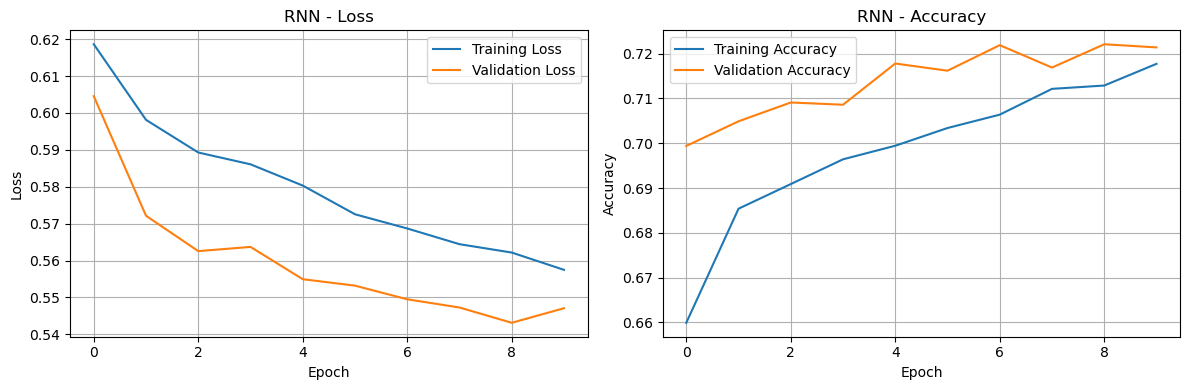


LEVEL 2: TRAINING LSTM MODEL
LSTM Model Summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │    13,088,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,088,100 (49.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,088,100 (49.93 MB)


Training LSTM
Epoch 1/10
 643/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6527 - loss: 0.6161 

KeyboardInterrupt: 

In [49]:
# Training parameters
EPOCHS = 10
BATCH_SIZE = 64

# Store models and histories
models = {}
histories = {}

# --- Train RNN Model (Level 1) ---
print("\n" + "="*70)
print("LEVEL 1: TRAINING RNN MODEL")
print("="*70)
rnn_model = build_rnn_model()
rnn_history = train_model(rnn_model, x_train, y_train, x_val, y_val, "RNN", EPOCHS, BATCH_SIZE)
plot_training_history(rnn_history, "RNN")
models['RNN'] = rnn_model
histories['RNN'] = rnn_history

# --- Train LSTM Model (Level 2) ---
print("\n" + "="*70)
print("LEVEL 2: TRAINING LSTM MODEL")
print("="*70)
lstm_model = build_lstm_model()
lstm_history = train_model(lstm_model, x_train, y_train, x_val, y_val, "LSTM", EPOCHS, BATCH_SIZE)
plot_training_history(lstm_history, "LSTM")
models['LSTM'] = lstm_model
histories['LSTM'] = lstm_history

# --- Train GRU Model (Level 3) ---
print("\n" + "="*70)
print("LEVEL 3: TRAINING GRU MODEL")
print("="*70)
gru_model = build_gru_model()
gru_history = train_model(gru_model, x_train, y_train, x_val, y_val, "GRU", EPOCHS, BATCH_SIZE)
plot_training_history(gru_history, "GRU")
models['GRU'] = gru_model
histories['GRU'] = gru_history


MODEL EVALUATION ON TEST SET

Evaluating RNN...
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

RNN Evaluation:
  Accuracy: 0.7084
  F1-Score: 0.7158


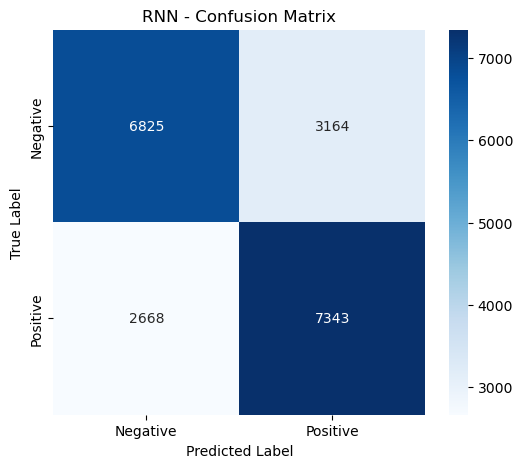


Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.68      0.70      9989
    Positive       0.70      0.73      0.72     10011

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000


Evaluating LSTM...
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

LSTM Evaluation:
  Accuracy: 0.7598
  F1-Score: 0.7693


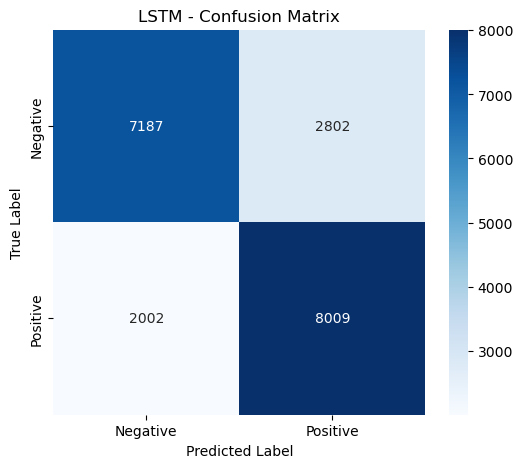


Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.72      0.75      9989
    Positive       0.74      0.80      0.77     10011

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000


Evaluating GRU...
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

GRU Evaluation:
  Accuracy: 0.4995
  F1-Score: 0.0000


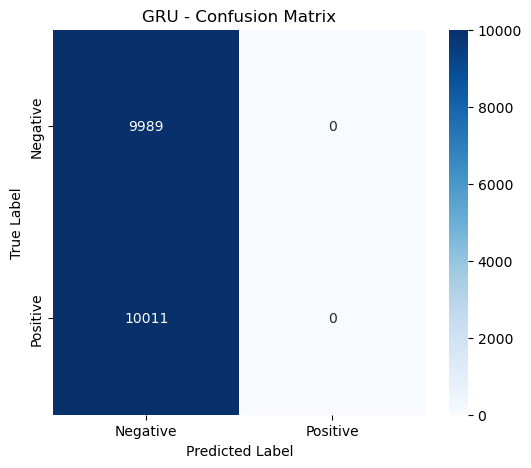


Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67      9989
    Positive       0.00      0.00      0.00     10011

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



In [35]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, x_test, y_test, model_name):
    """Evaluate model and return metrics"""
    # Make predictions
    y_pred_proba = model.predict(x_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{model_name} Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    
    return accuracy, f1, y_pred_proba

# Evaluate all models
results = {}
print("\n" + "="*70)
print("MODEL EVALUATION ON TEST SET")
print("="*70)

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    accuracy, f1, pred_proba = evaluate_model(model, x_test, y_test, model_name)
    results[model_name] = {
        'accuracy': accuracy,
        'f1': f1,
        'model': model
    }

In [36]:
def error_analysis(model, x_test, y_test, test_df, model_name):
    """Analyze errors made by the model"""
    # Get predictions
    y_pred_proba = model.predict(x_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Find errors
    errors = np.where(y_pred.flatten() != y_test.flatten())[0]
    
    print(f"\n{model_name} Error Analysis:")
    print(f"Total test samples: {len(y_test)}")
    print(f"Errors: {len(errors)} ({len(errors)/len(y_test):.2%})")
    
    if len(errors) > 0:
        # Show some error examples
        print("\nSample errors:")
        for i in errors[:3]:  # Show first 3 errors
            original_text = test_df['text'].iloc[i]
            true_label = "Positive" if y_test[i][0] == 1 else "Negative"
            pred_label = "Positive" if y_pred[i][0] == 1 else "Negative"
            confidence = y_pred_proba[i][0] if pred_label == "Positive" else 1 - y_pred_proba[i][0]
            
            print(f"\nError {i}:")
            print(f"  Text: '{original_text[:100]}...'")
            print(f"  True: {true_label}")
            print(f"  Pred: {pred_label} (confidence: {confidence:.3f})")

# Perform error analysis for each model
print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

for model_name, model in models.items():
    error_analysis(model, x_test, y_test, test_df, model_name)


ERROR ANALYSIS
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

RNN Error Analysis:
Total test samples: 20000
Errors: 5832 (29.16%)

Sample errors:

Error 1:
  Text: '11 days and my dream comes true. I wanted this since I was 5.  STOKED....'
  True: Positive
  Pred: Negative (confidence: 0.815)

Error 8:
  Text: '@missionsguru whew! I was SO worried about the reality of your southern roots. Only for a moment tho...'
  True: Positive
  Pred: Negative (confidence: 0.797)

Error 11:
  Text: '@whoizat515  thanks!  You can never go wrong with Radiohead  â« http://blip.fm/~7glj1...'
  True: Positive
  Pred: Negative (confidence: 0.608)
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

LSTM Error Analysis:
Total test samples: 20000
Errors: 4804 (24.02%)

Sample errors:

Error 1:
  Text: '11 days and my dream comes true. I wanted this since I was 5.  STOKED....'
  True: Positive
  Pred: Negative (confidence: 0.756)

Error 8:
  Text: '@missionsguru whew! I was SO worried about the reality of your southern r

In [37]:
def predict_sentiment_live(text, models_dict, tokenizer):
    """Predict sentiment for live text input"""
    # Preprocess text
    cleaned_text = preprocess_text(text)
    
    # Tokenize
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=MAX_SEQ_LENGTH,
        padding='post',
        truncating='post'
    )
    
    predictions = {}
    for model_name, model in models_dict.items():
        pred = model.predict(padded, verbose=0)[0][0]
        sentiment = "positive" if pred > 0.5 else "negative"
        score = float(pred)
        
        predictions[model_name] = {
            'sentiment': sentiment,
            'score': score
        }
    
    return predictions

# Test with example sentences
print("\n" + "="*70)
print("LIVE PREDICTION DEMONSTRATION")
print("="*70)

test_sentences = [
    "I like reading.",
    "This movie was terrible and boring.",
    "Great service, highly recommended!",
    "I'm not happy with the product quality.",
    "Amazing experience, will come again!"
]

for sentence in test_sentences:
    print(f"\nInput: '{sentence}'")
    predictions = predict_sentiment_live(sentence, models, tokenizer)
    
    for model_name, pred in predictions.items():
        print(f"  {model_name}: {pred['sentiment']}, score: {pred['score']:.8f}")


LIVE PREDICTION DEMONSTRATION

Input: 'I like reading.'
  RNN: positive, score: 0.83050054
  LSTM: positive, score: 0.68457085
  GRU: negative, score: 0.49528173

Input: 'This movie was terrible and boring.'
  RNN: negative, score: 0.19029537
  LSTM: negative, score: 0.02629208
  GRU: negative, score: 0.49528173

Input: 'Great service, highly recommended!'
  RNN: positive, score: 0.83209956
  LSTM: positive, score: 0.95145428
  GRU: negative, score: 0.49528173

Input: 'I'm not happy with the product quality.'
  RNN: positive, score: 0.83103609
  LSTM: positive, score: 0.92189312
  GRU: negative, score: 0.49528173

Input: 'Amazing experience, will come again!'
  RNN: positive, score: 0.83195245
  LSTM: positive, score: 0.94694823
  GRU: negative, score: 0.49528173


In [38]:
# Create models directory
MODELS_DIR = os.path.join(BASE_DIR, 'saved_models')
os.makedirs(MODELS_DIR, exist_ok=True)

# Save models
print("\nSaving models...")
for model_name, model in models.items():
    model_path = os.path.join(MODELS_DIR, f'{model_name.lower()}_model.h5')
    model.save(model_path)
    print(f"  Saved {model_name} to {model_path}")

# Save tokenizer
import pickle
tokenizer_path = os.path.join(MODELS_DIR, 'tokenizer.pickle')
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"  Saved tokenizer to {tokenizer_path}")

# Save preprocessing parameters
params = {
    'MAX_SEQ_LENGTH': MAX_SEQ_LENGTH,
    'MAX_WORDS': MAX_WORDS,
    'EMBEDDING_DIM': EMBEDDING_DIM
}
import json
params_path = os.path.join(MODELS_DIR, 'params.json')
with open(params_path, 'w') as f:
    json.dump(params, f)
print(f"  Saved parameters to {params_path}")


Saving models...


  Saved RNN to /home/sakhawat/workspace/Python/ml/Emotion-Analysis/saved_models/rnn_model.h5
  Saved LSTM to /home/sakhawat/workspace/Python/ml/Emotion-Analysis/saved_models/lstm_model.h5
  Saved GRU to /home/sakhawat/workspace/Python/ml/Emotion-Analysis/saved_models/gru_model.h5
  Saved tokenizer to /home/sakhawat/workspace/Python/ml/Emotion-Analysis/saved_models/tokenizer.pickle
  Saved parameters to /home/sakhawat/workspace/Python/ml/Emotion-Analysis/saved_models/params.json


In [39]:
# Create a simple text-based UI for demonstration
ui_code = '''
import numpy as np
import tensorflow as tf
import pickle
import json
import os
import re

class SimpleSentimentUI:
    def __init__(self):
        # Load models and tokenizer
        self.load_models()
        
    def load_models(self):
        """Load saved models"""
        self.models_dir = 'saved_models'
        
        # Load tokenizer
        with open(os.path.join(self.models_dir, 'tokenizer.pickle'), 'rb') as f:
            self.tokenizer = pickle.load(f)
        
        # Load parameters
        with open(os.path.join(self.models_dir, 'params.json'), 'r') as f:
            params = json.load(f)
            self.max_seq_length = params['MAX_SEQ_LENGTH']
        
        # Load models
        self.models = {}
        for model_name in ['RNN', 'LSTM', 'GRU']:
            model_path = os.path.join(self.models_dir, f'{model_name.lower()}_model.h5')
            if os.path.exists(model_path):
                self.models[model_name] = tf.keras.models.load_model(model_path)
                print(f"Loaded {model_name} model")
        
        print(f"Loaded {len(self.models)} models")
    
    def preprocess_text(self, text):
        """Simple text preprocessing"""
        text = re.sub(r'[^A-Za-z0-9\s]+', ' ', str(text).lower()).strip()
        return ' '.join(text.split())
    
    def predict(self, text):
        """Predict sentiment for given text"""
        # Preprocess
        cleaned_text = self.preprocess_text(text)
        
        # Tokenize
        sequence = self.tokenizer.texts_to_sequences([cleaned_text])
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            sequence,
            maxlen=self.max_seq_length,
            padding='post',
            truncating='post'
        )
        
        predictions = {}
        for model_name, model in self.models.items():
            pred = model.predict(padded, verbose=0)[0][0]
            sentiment = "positive" if pred > 0.5 else "negative"
            predictions[model_name] = {
                'sentiment': sentiment,
                'score': float(pred)
            }
        
        return predictions
    
    def run(self):
        """Run the interactive UI"""
        print("=" * 60)
        print("SENTIMENT ANALYSIS DEMO")
        print("=" * 60)
        print("Type 'quit' to exit")
        print("=" * 60)
        
        while True:
            text = input("\nEnter text to analyze: ").strip()
            
            if text.lower() == 'quit':
                print("Goodbye!")
                break
            
            if not text:
                continue
            
            print(f"\nAnalyzing: '{text}'")
            predictions = self.predict(text)
            
            for model_name, pred in predictions.items():
                print(f"{model_name}: {pred['sentiment']}, score: {pred['score']:.8f}")

if __name__ == "__main__":
    ui = SimpleSentimentUI()
    ui.run()
'''

# Save UI script
ui_file = os.path.join(BASE_DIR, 'sentiment_demo.py')
with open(ui_file, 'w') as f:
    f.write(ui_code)

print(f"\nSimple UI script saved to: {ui_file}")
print("\nTo run the demo:")
print(f"python {ui_file}")


Simple UI script saved to: /home/sakhawat/workspace/Python/ml/Emotion-Analysis/sentiment_demo.py

To run the demo:
python /home/sakhawat/workspace/Python/ml/Emotion-Analysis/sentiment_demo.py
